In [2]:
import torch
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from utils import prepare_data
import matplotlib.pyplot as plt
import inspect

/home/vansh/whisper-stream/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
my_model = WhisperForConditionalGeneration.from_pretrained("./whisper_causal_3/checkpoint-109000")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
processor = WhisperProcessor.from_pretrained("openai/whisper-base")

for layer in my_model.model.encoder.layers:        
    layer.self_attn.is_causal = True          # type: ignore[attr-defined]

In [ ]:
print(inspect.getsource(my_model.forward))

In [ ]:
ds = prepare_data(max_shards=5)

my_model_loss = []
whisper_model_loss = []

for i in range(100):
    sample = ds[i]                                            # type: ignore[attr-defined]
    audio = torch.from_numpy(sample["mp3"]["array"]).float()  # type: ignore[attr-defined]
    text = sample["json"]["text"]                             # type: ignore[attr-defined]
    
    labels = torch.tensor(processor.tokenizer(text, add_special_tokens=False).input_ids).unsqueeze(0)  # type: ignore[attr-defined]
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt")                                # type: ignore[attr-defined]
    
    with torch.no_grad():
        my_outputs = my_model(
            inputs.input_features, 
            labels=labels
            )
        whisper_outputs_base = whisper_model(
            inputs.input_features, 
            labels=labels
            )
        
        generated_ids = whisper_model.generate(
            inputs.input_features, 
            temperature=0.5,  # Very deterministic
            do_sample=True    # Must set this to True for temperature to work
        )

        generated_ids = whisper_model.generate(
            inputs.input_features, 
            temperature=0.5,  # More creative/random
            do_sample=True
        )
        
    my_results = processor.batch_decode(my_outputs.logits.argmax(dim=-1), skip_special_tokens=True)[0]  # type: ignore[attr-defined]
    whisper_results = processor.batch_decode(whisper_outputs_base.logits.argmax(dim=-1), skip_special_tokens=True)[0]  # type: ignore[attr-defined]
        
    
    my_model_loss.append(my_outputs.loss.item())
    whisper_model_loss.append(whisper_outputs_base.loss.item())
    # print(f"Truth: {text}")
    # print(f"Mine: {my_results}")
    # print(f"Base: {whisper_results}")
    print("\n")
  

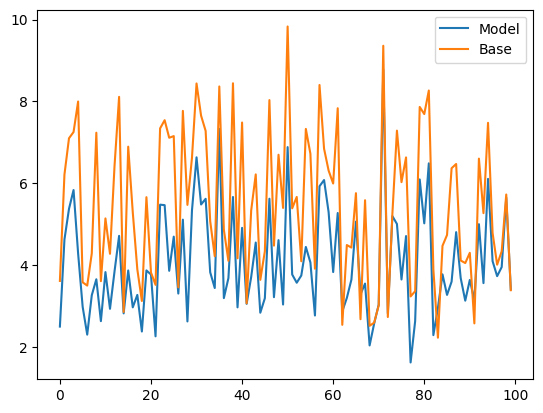

In [9]:
plt.plot(my_model_loss, label="Model")
plt.plot(whisper_model_loss, label="Base")
plt.legend()

In [9]:
print(f"Model Loss: {sum(my_model_loss) / len(my_model_loss)}")
print(f"Whisper Loss: {sum(whisper_model_loss) / len(whisper_model_loss)}")

Model Loss: 4.401216140985489
Whisper Loss: 5.474421148300171
